In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
sm = np.load('/hard/lilu/SM.npy')

In [3]:
sm.shape

(8036, 1, 448, 672)

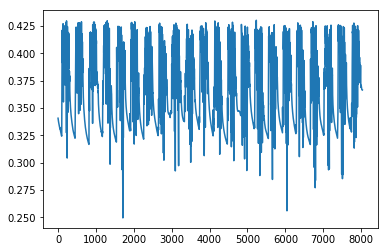

In [8]:
plt.plot(sm[:,0,100,100])

In [3]:
cly = np.load('/hard/lilu/SMAP_L4/SoilAttributes/SoilGrids/CLY_sl1_SG_1km.npy')

In [2]:
x_train_1 = np.load('/hard/lilu/x_train_1.npy')
y_train_1 = np.load('/hard/lilu/y_train_1.npy')
x_valid_1 = np.load('/hard/lilu/x_valid_1.npy')
y_valid_1 = np.load('/hard/lilu/y_valid_1.npy')
x_test_1 = np.load('/hard/lilu/x_test_1.npy')
y_test_1 = np.load('/hard/lilu/y_test_1.npy')

In [6]:
a = np.load('/hard/lilu/z_train_1.npy')

In [7]:
a.shape

(1828, 1, 112, 112, 5)

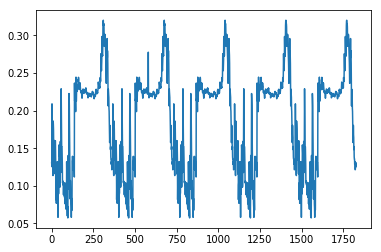

In [4]:
plt.plot(a[:,0,0,0,3])

In [3]:
x_train_1.shape

(1462, 7, 224, 224)

In [4]:
y_train_1.shape

(1462, 1, 224, 224)

In [2]:
y_train_pred_1 = np.load('/hard/lilu/y_train_pred_1.npy')
y_test_pred_1 = np.load('/hard/lilu/y_test_pred_1.npy')
y_valid_pred_1 = np.load('/hard/lilu/y_valid_pred_1.npy')

In [3]:
y_train_obs_1 = np.load('/hard/lilu/y_train_obs_1.npy')
y_test_obs_1 = np.load('/hard/lilu/y_test_obs_1.npy')
y_valid_obs_1 = np.load('/hard/lilu/y_valid_obs_1.npy')

In [6]:
y_test_pred_1 = y_test_pred_1[:,np.newaxis]
y_train_pred_1 = y_train_pred_1[:,np.newaxis]
y_valid_pred_1 = y_valid_pred_1[:,np.newaxis]

In [4]:
y_test_pred_1.shape

(512, 1, 112, 112, 1)

In [5]:
y_test_obs_1.shape

(512, 1, 112, 112, 1)

In [6]:
r2_train = np.full((7, 224, 224), np.nan)
r2_valid = np.full((7, 224, 224), np.nan)
r2_test = np.full((7, 224, 224), np.nan)

r_train = np.full((7, 224, 224), np.nan)
r_test = np.full((7, 224, 224), np.nan)
r_valid = np.full((7, 224, 224), np.nan)

rmse_train = np.full((7, 224, 224), np.nan)
rmse_test = np.full((7, 224, 224), np.nan)
rmse_valid = np.full((7, 224, 224), np.nan)

from sklearn.metrics import r2_score, mean_squared_error

for i in range(1):
    for j in range(112):
        for k in range(112):
            
            #r2_train[i,j,k] = r2_score(y_train_obs_1[:,i, j,k,0],y_train_pred_1[:,i,j,k,0])
            r2_test[i,j,k] = r2_score(y_test_obs_1[:,i, j,k,0],y_test_pred_1[:,i,j,k,0])
            #r2_valid[i,j,k] = r2_score(y_valid_obs_1[:, i,j,k,0],y_valid_pred_1[:,i,j,k,0])
   
            #r_train[i,j,k] = np.corrcoef(y_train_obs_1[:, i,j,k,0],y_train_pred_1[:,i,j,k,0])[0,1]
            r_test[i,j,k] = np.corrcoef(y_test_obs_1[:,i, j,k,0],y_test_pred_1[:,i,j,k,0])[0,1]
            #r_valid[i,j,k] = np.corrcoef(y_valid_obs_1[:, i,j,k,0],y_valid_pred_1[:,i,j,k,0])[0,1]

            #rmse_train[i,j,k] = np.sqrt(mean_squared_error(y_train_obs_1[:, i, j,k,0],y_train_pred_1[:,i,j,k,0]))
            rmse_test[i,j,k] = np.sqrt(mean_squared_error(y_test_obs_1[:, i,j,k,0],y_test_pred_1[:,i,j,k,0]))
            #rmse_valid[i,j,k] = np.sqrt(mean_squared_error(y_valid_obs_1[:, i,j,k,0],y_valid_pred_1[:,i,j,k,0]))        

In [9]:
r_test.shape

(7, 224, 224)

In [6]:
r2_test0 = r2_test
r_test0 = r_test
rmse_test0 = rmse_test

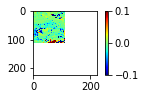

In [10]:
plt.subplot(3,2,2)
plt.imshow(r2_test0[0]-r2_test[0],vmin=-0.1,vmax=0.1, cmap='jet')
plt.colorbar()


In [11]:
np.nanmean(r2_test0[0]-r2_test[0])

-0.013974411334036853

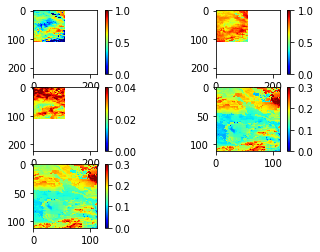

In [7]:
plt.subplot(3,2,1)
plt.imshow(r2_test[0,:,:],vmin=0, vmax=1, cmap='jet')
plt.colorbar()

plt.subplot(3,2,2)
plt.imshow(r_test[0, :,:],vmin=0, vmax=1, cmap='jet')
plt.colorbar()

plt.subplot(3,2,3)
plt.imshow(rmse_test[0, :,:],vmin=0, vmax=0.04, cmap='jet')
plt.colorbar()

plt.subplot(3,2,4)
plt.imshow(np.nanmean(y_test_obs_1[:, 0,:,:,0],axis=0),vmin=0, vmax=0.3, cmap='jet')
plt.colorbar()

plt.subplot(3,2,5)
plt.imshow(np.nanmean(y_test_pred_1[:, 0,:,:,0],axis=0),vmin=0, vmax=0.3, cmap='jet')
plt.colorbar()

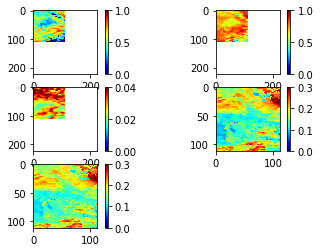

In [7]:
plt.subplot(3,2,1)
plt.imshow(r2_test[0,:,:],vmin=0, vmax=1, cmap='jet')
plt.colorbar()

plt.subplot(3,2,2)
plt.imshow(r_test[0,:,:],vmin=0, vmax=1, cmap='jet')
plt.colorbar()

plt.subplot(3,2,3)
plt.imshow(rmse_test[0, :,:],vmin=0, vmax=0.04, cmap='jet')
plt.colorbar()

plt.subplot(3,2,4)
plt.imshow(np.nanmean(y_test_obs_1[:, 0,:,:,0],axis=0),vmin=0, vmax=0.3, cmap='jet')
plt.colorbar()

plt.subplot(3,2,5)
plt.imshow(np.nanmean(y_test_pred_1[:, 0,:,:,0],axis=0),vmin=0, vmax=0.3, cmap='jet')
plt.colorbar()

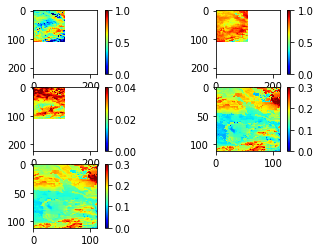

In [8]:
plt.subplot(3,2,1)
plt.imshow(r2_test[0,:,:],vmin=0, vmax=1, cmap='jet')
plt.colorbar()

plt.subplot(3,2,2)
plt.imshow(r_test[0, :,:],vmin=0, vmax=1, cmap='jet')
plt.colorbar()

plt.subplot(3,2,3)
plt.imshow(rmse_test[0, :,:],vmin=0, vmax=0.04, cmap='jet')
plt.colorbar()

plt.subplot(3,2,4)
plt.imshow(np.nanmean(y_test_obs_1[:, 0,:,:,0],axis=0),vmin=0, vmax=0.3, cmap='jet')
plt.colorbar()

plt.subplot(3,2,5)
plt.imshow(np.nanmean(y_test_pred_1[:, 0,:,:,0],axis=0),vmin=0, vmax=0.3, cmap='jet')
plt.colorbar()

In [13]:
r_test[0]

array([[0.63855391, 0.25727879, 0.2384645 , ...,        nan,        nan,
               nan],
       [0.59540609, 0.59557204, 0.5787905 , ...,        nan,        nan,
               nan],
       [0.5797199 , 0.63527328, 0.57493783, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

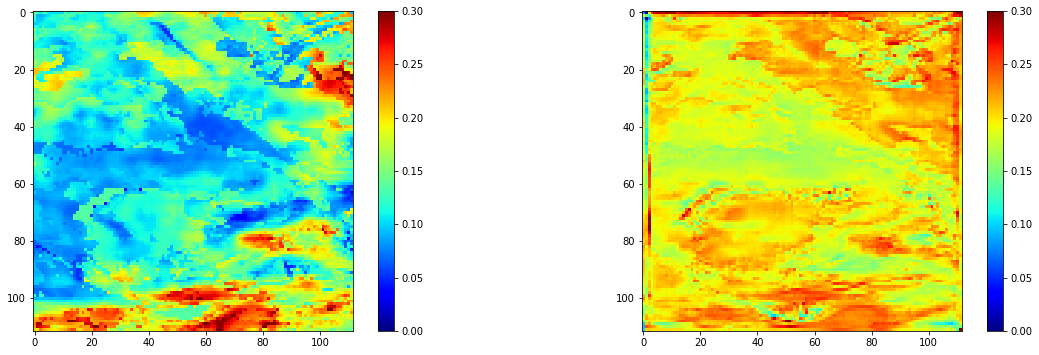

In [11]:
plt.figure(figsize=(20,20))

plt.subplot(3,2,1)
plt.imshow(y_test_obs_1[6, 0,:,:,0],vmin=0, vmax=0.3, cmap='jet')
plt.colorbar()

plt.subplot(3,2,2)
plt.imshow(y_test_pred_1[6, 0,:,:,0],vmin=0, vmax=0.3, cmap='jet')
plt.colorbar()

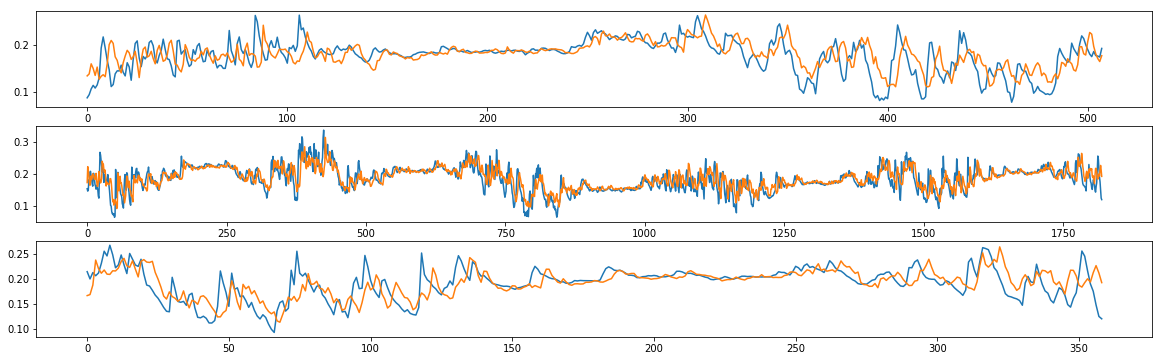

In [12]:
plt.figure(figsize=(20,6))
plt.subplot(3,1,1)
plt.plot(y_test_obs_1[:, 3, 100, 100, 0])
plt.plot(y_test_pred_1[:, 3, 100, 100, 0])

plt.subplot(3,1,2)
plt.plot(y_train_obs_1[:,  3, 100, 100, 0])
plt.plot(y_train_pred_1[:, 3, 100, 100, 0])


plt.subplot(3,1,3)
plt.plot(y_valid_obs_1[:,  3, 100, 100, 0])
plt.plot(y_valid_pred_1[:, 3, 100, 100, 0])